# Correction on a distrubed solution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
from utils import *
config = read_json_file()
# method = config["method"]
# method = method.lower()
method = "phifem"
if method == "fem":
    from solver_fem import *
    ClassSolver = FEMSolver
elif method == "phifem":
    from solver_phifem import *
    ClassSolver = PhiFemSolver
else:
    raise ValueError("Method not recognized")

geometry = config["geometry"]
if geometry == "circle":
    from data_circle import *
    int_a = 0.0
    int_b = 1.0
elif geometry == "square":
    from data_square import *
    int_a = -0.5
    int_b = 1.5

homogeneous = config["homogeneous"]
S,Sp = (0.5,0.5)
pp = 0.
if homogeneous:
    p = 0.
else:
    p = 1.

bash: /home/lecourtier/anaconda3/envs/env_tensorflow/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/lecourtier/anaconda3/envs/env_tensorflow/lib/libtinfo.so.6: no version information available (required by bash)


In [4]:
import os

result_dir = "results/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

if homogeneous:
    result_dir += "homogeneous/"
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
else:
    result_dir += "non_homogeneous/"
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
result_dir += method+"_"+geometry+"/"
if not os.path.exists(result_dir):
        os.makedirs(result_dir)
print(result_dir)

results/homogeneous/phifem_circle/


In [5]:
import numpy as np
import pandas as pd
import dataframe_image as dfi
from dolfin import *

import seaborn as sns

sns.set_theme(style="whitegrid")
# sns.set_context("paper")
# sns.set(rc={"xtick.bottom": True, "ytick.left": True})

# noinspection PyUnresolvedReferences
from dolfin import parameters
import matplotlib.pyplot as plt

parameters["ghost_mode"] = "shared_facet"
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True
parameters["allow_extrapolation"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 10

## Data

In [6]:
def test_omega():
    mask = omega_mask(64)
    plt.imshow(mask)
    plt.colorbar()
    plt.show()

# test_omega()

In [7]:
def plot_data(F,U):
    mask = omega_mask(100)
    plt.figure(figsize=(9,3))

    plt.subplot(1,2,1)
    plt.imshow(mask * F, origin="lower")
    plt.title("F")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(mask * U, origin="lower")
    plt.title("U_ex")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

def test():
    f,fp = (4,1)
    XXYY = get_vert_coord(nb_vert=100)
    F = np.reshape(call_F(np,XXYY,S,f,p),[100,100])
    U = np.reshape(call_Y_true(np,XXYY,S,f,p),[100,100])
    plot_data(F,U)

# test()

## Results

In [18]:
nb_vert = 32
tab_eps = [1]+[10**(-i) for i in range(1,5)]+[0.]
eps_str = ["eps = " + str(eps) for eps in tab_eps]
f,fp = 1,2

In [19]:
save_file = result_dir
if not os.path.exists(save_file):
    os.makedirs(save_file)

In [20]:
params = [[S,f,p]]
params_pert = [[Sp,fp,pp]]
print("params : ",params)
print("params_pert : ",params_pert)
freqs_str = ["f = " + str(f) + " ; fp = " + str(fp) for ((S,f,p),(Sp,fp,pp)) in zip(params,params_pert)]

params :  [[0.5, 1, 0.0]]
params_pert :  [[0.5, 2, 0.0]]


In [21]:
solver = ClassSolver(nb_cell=nb_vert-1, params=params, params_pert=params_pert)

num of cell in the ghost penalty: 150


In [22]:
norms = []
for eps in tab_eps:
    print("## EPS : ",eps)
    sol, C_h, norm_L2 = solver.corr_add(0,eps)
    norms.append(norm_L2)
np.save(save_file+"norm_phi_tild", norms)
# df_mult = pd.DataFrame(np.transpose(norms_mult),columns=eps_str,index=freqs_str)
# df_mult

## EPS :  1
Solving linear variational problem.
## EPS :  0.1
Solving linear variational problem.
## EPS :  0.01
Solving linear variational problem.
## EPS :  0.001
Solving linear variational problem.
## EPS :  0.0001
Solving linear variational problem.
## EPS :  0.0
Solving linear variational problem.


<Figure size 640x480 with 0 Axes>

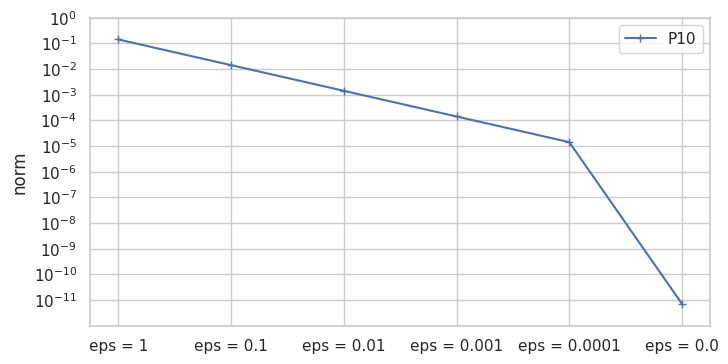

In [23]:
sns.despine(left=True)
# sns.set(style="ticks")
plt.figure(figsize=(8,4))
plt.semilogy(eps_str,norms,"+-",label="P10")
plt.ylabel("norm")
plt.yticks([10**(-i) for i in range(12)])
plt.ylim([10**(-12),10**(0)])
plt.legend()
plt.show()
# plt.savefig(save_file+"norms_P10.png",bbox_inches='tight')

In [24]:
tab_data = np.array([tab_eps,norms])

In [25]:
import pandas as pd

data = pd.DataFrame(tab_data, index=["eps", "corr_add"])
data = data.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
data.set_properties(**{'text-align': 'center'}).hide(axis='columns')
pd.set_option('colheader_justify', 'center')

In [26]:
data

eps,1.000000,0.100000,0.010000,0.001000,0.000100,0.000000
corr_add,0.143091,0.014309,0.001431,0.000143,0.000014,0.000000


In [17]:
# df_styled = data.format("{:.2e}")

# dfi.export(data, save_file+"norms.png", dpi=300)
